In [1]:
import os

import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [8]:
g = GaiaData(at.Table.read('../data/TheOGGroup.csv', format='ascii.ecsv'))
len(g)

41

Now we have ~40 candidate members!

In [9]:
highprob_c = g.get_skycoord()

In [24]:
# Absolute magnitude, color - not extinction corrected
# mg = g.phot_g_mean_mag - g.distmod
# bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag

# Absolute magnitude, color - extinction corrected
mg = g.get_G0() - g.distmod
bprp = g.get_BP0() - g.get_RP0()

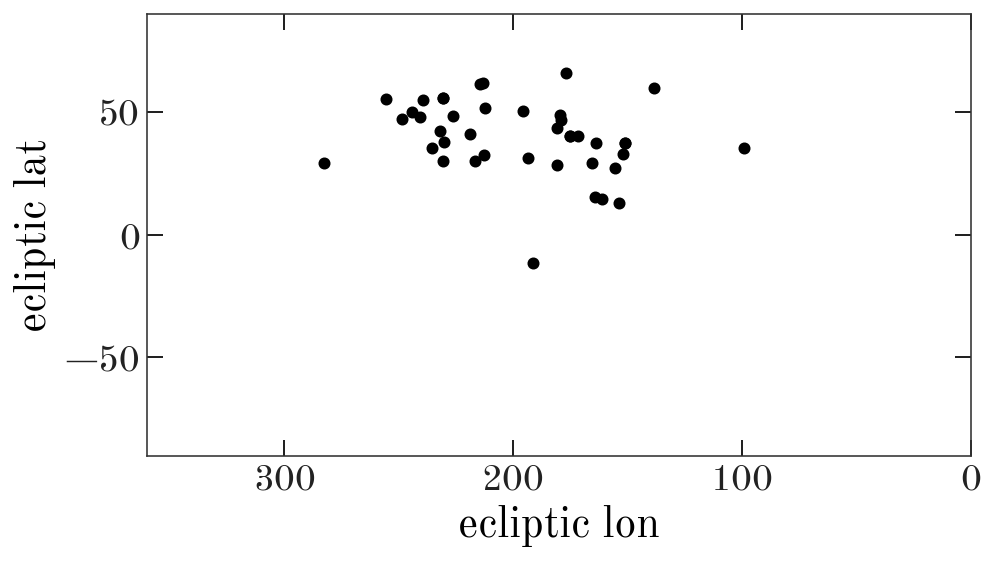

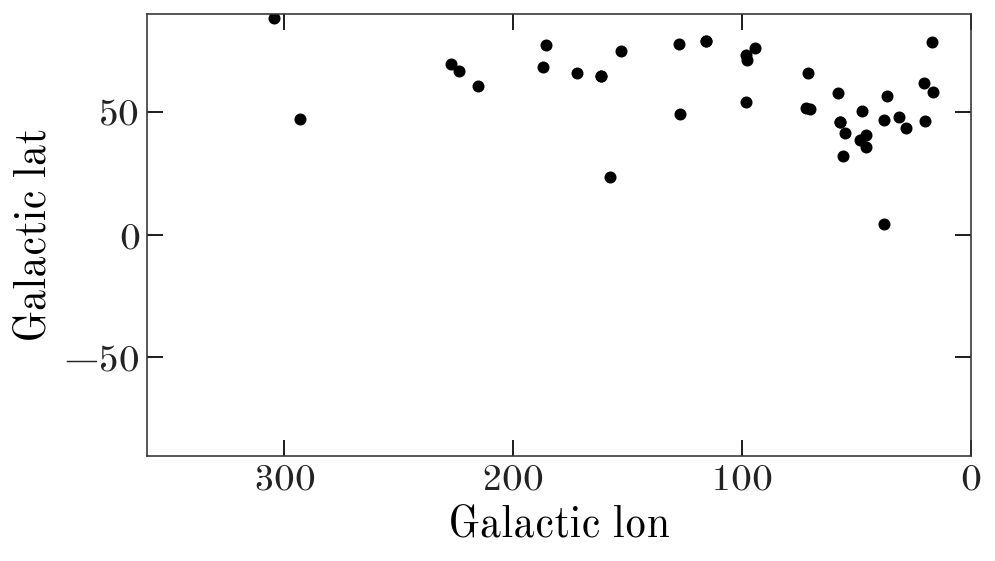

In [25]:
plt.figure(figsize=(7, 4))
plt.scatter(highprob_c.barycentricmeanecliptic.lon.degree,
            highprob_c.barycentricmeanecliptic.lat.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel('ecliptic lon')
plt.ylabel('ecliptic lat')
plt.tight_layout()

plt.figure(figsize=(7, 4))
plt.scatter(highprob_c.galactic.l.degree,
            highprob_c.galactic.b.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel('Galactic lon')
plt.ylabel('Galactic lat')
plt.tight_layout()

Color-magnitude diagrams with isochrones:

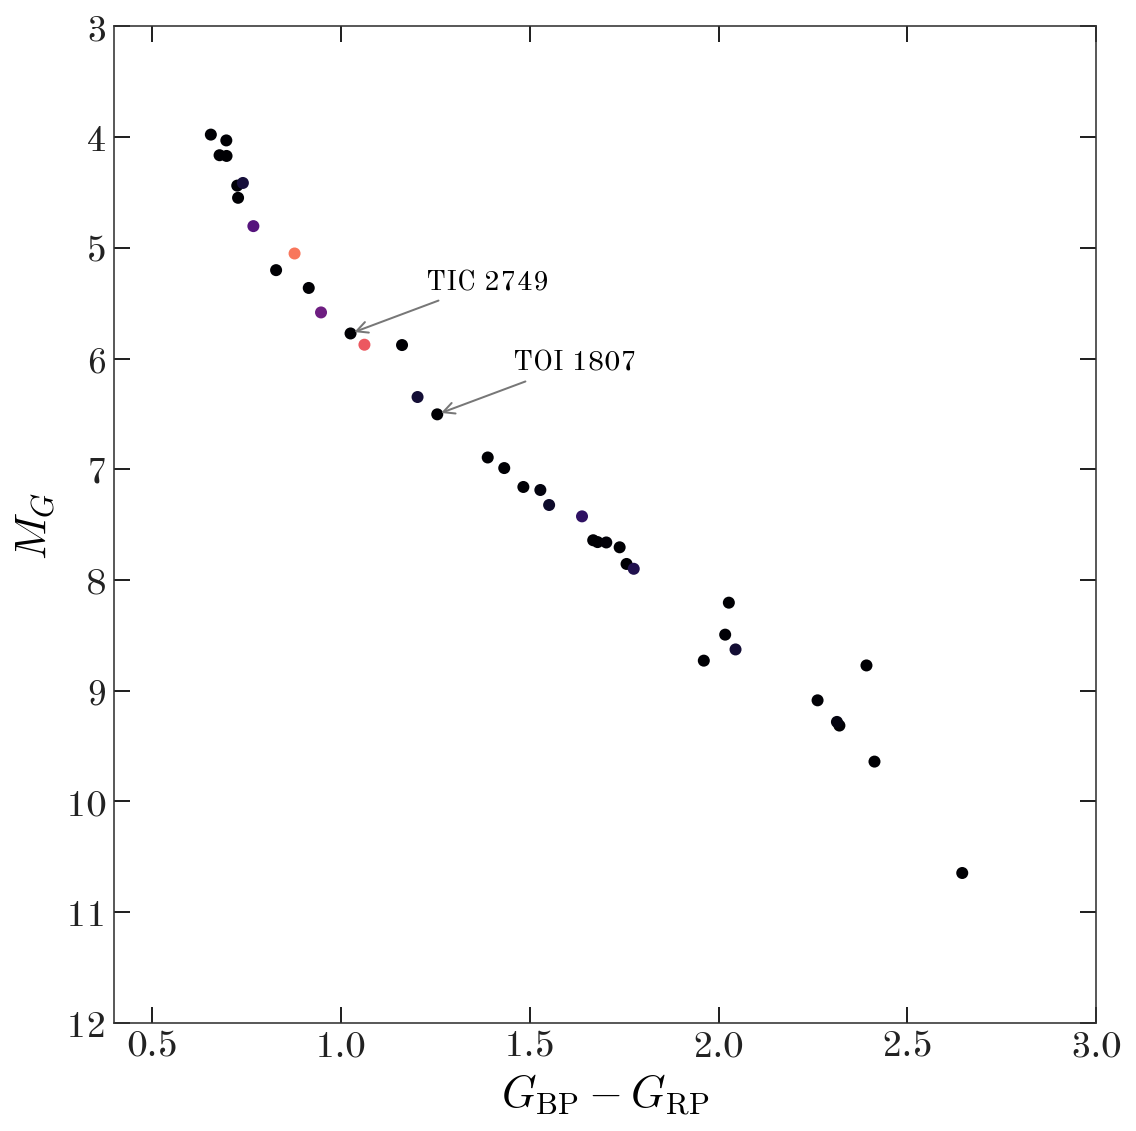

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(bprp, mg, c=g.prob, 
           cmap='magma_r', vmin=0.5, vmax=1)

ax.annotate('TIC 2749',
            (bprp[g.source_id == 1490845584382687232].value, 
             mg[g.source_id == 1490845584382687232].value),
            xytext=(bprp[g.source_id == 1490845584382687232].value + 0.2, 
                    mg[g.source_id == 1490845584382687232].value - 0.4),
            arrowprops=dict(arrowstyle='->', color='#777777'), fontsize=14)

ax.annotate('TOI 1807',
            (bprp[g.source_id == 1476485996883837184].value, 
             mg[g.source_id == 1476485996883837184].value),
            xytext=(bprp[g.source_id == 1476485996883837184].value + 0.2, 
                    mg[g.source_id == 1476485996883837184].value - 0.4),
            arrowprops=dict(arrowstyle='->', color='#777777'), fontsize=14)

ax.set_xlim(0.4, 3)
ax.set_ylim(12, 3)

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')
fig.tight_layout()

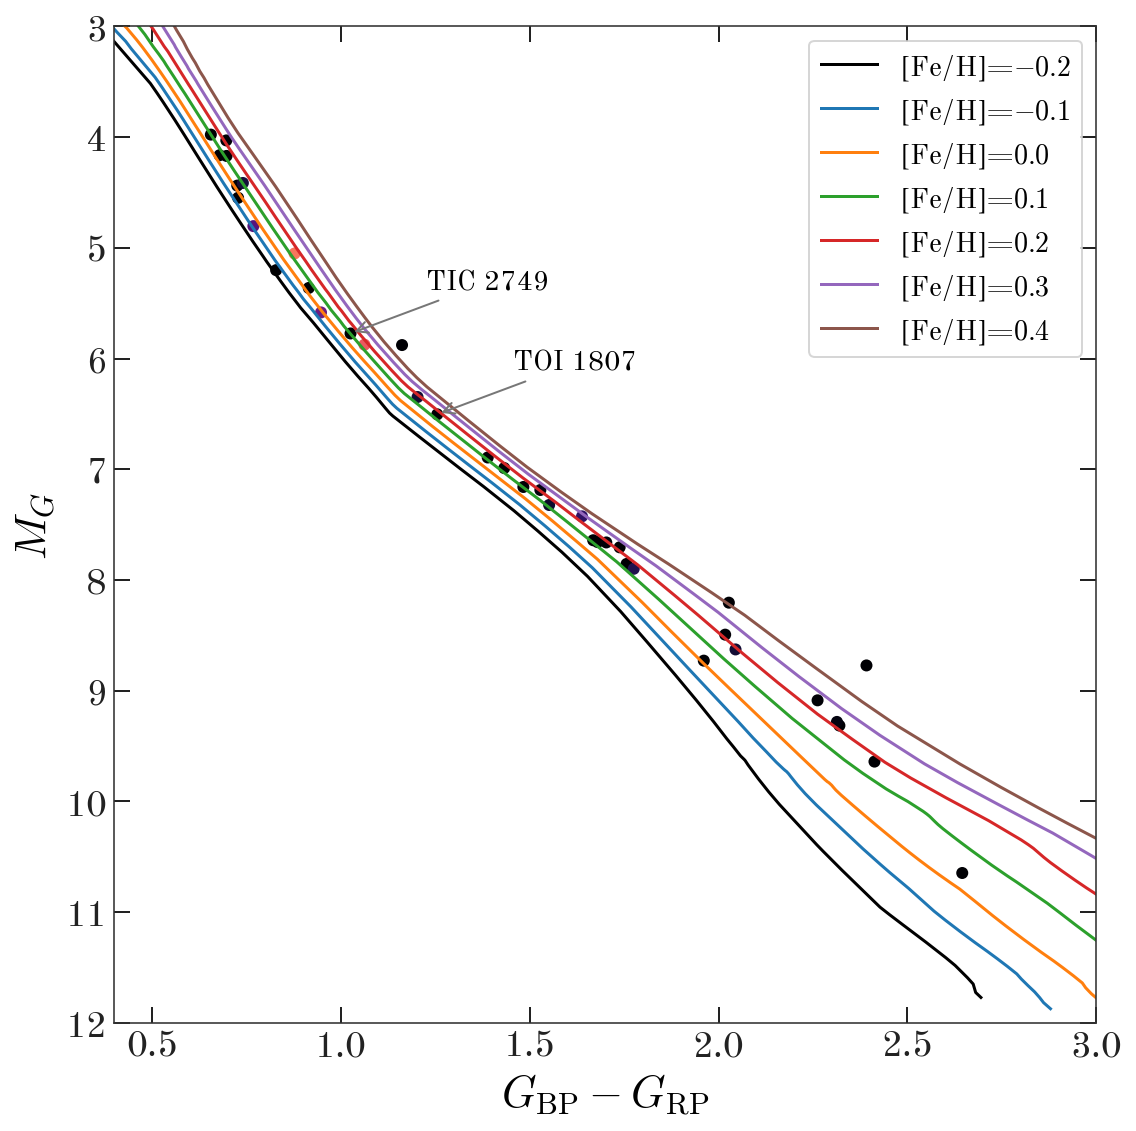

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(bprp, mg, c=g.prob, 
           cmap='magma_r', vmin=0.5, vmax=1)

ax.annotate('TIC 2749',
            (bprp[g.source_id == 1490845584382687232].value, 
             mg[g.source_id == 1490845584382687232].value),
            xytext=(bprp[g.source_id == 1490845584382687232].value + 0.2, 
                    mg[g.source_id == 1490845584382687232].value - 0.4),
            arrowprops=dict(arrowstyle='->', color='#777777'), fontsize=14)

ax.annotate('TOI 1807',
            (bprp[g.source_id == 1476485996883837184].value, 
             mg[g.source_id == 1476485996883837184].value),
            xytext=(bprp[g.source_id == 1476485996883837184].value + 0.2, 
                    mg[g.source_id == 1476485996883837184].value - 0.4),
            arrowprops=dict(arrowstyle='->', color='#777777'), fontsize=14)

# for age in [7.7, 7.8, 8, 8.2, 8.4]:
#     i = iso[np.isclose(iso['log10_isochrone_age_yr'], age)]
#     ax.plot(i['G_BP']-i['G_RP'], i['G'])

for feh in np.arange(-0.2, 0.4+1e-3, 0.1):
    iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_{feh:.1f}_iso.fits')
    i = iso[np.isclose(iso['log10_isochrone_age_yr'], 7.8)]  # ~60 Myr
    i = i[i['phase'] < 4]  # rgb or before
    ax.plot(i['G_BP']-i['G_RP'], i['G'], marker='', label=f'[Fe/H]=${feh:.1f}$')

ax.set_xlim(0.4, 3)
ax.set_ylim(12, 3)

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

ax.legend(loc='upper right', fontsize=14)

fig.set_facecolor('w')
fig.tight_layout()

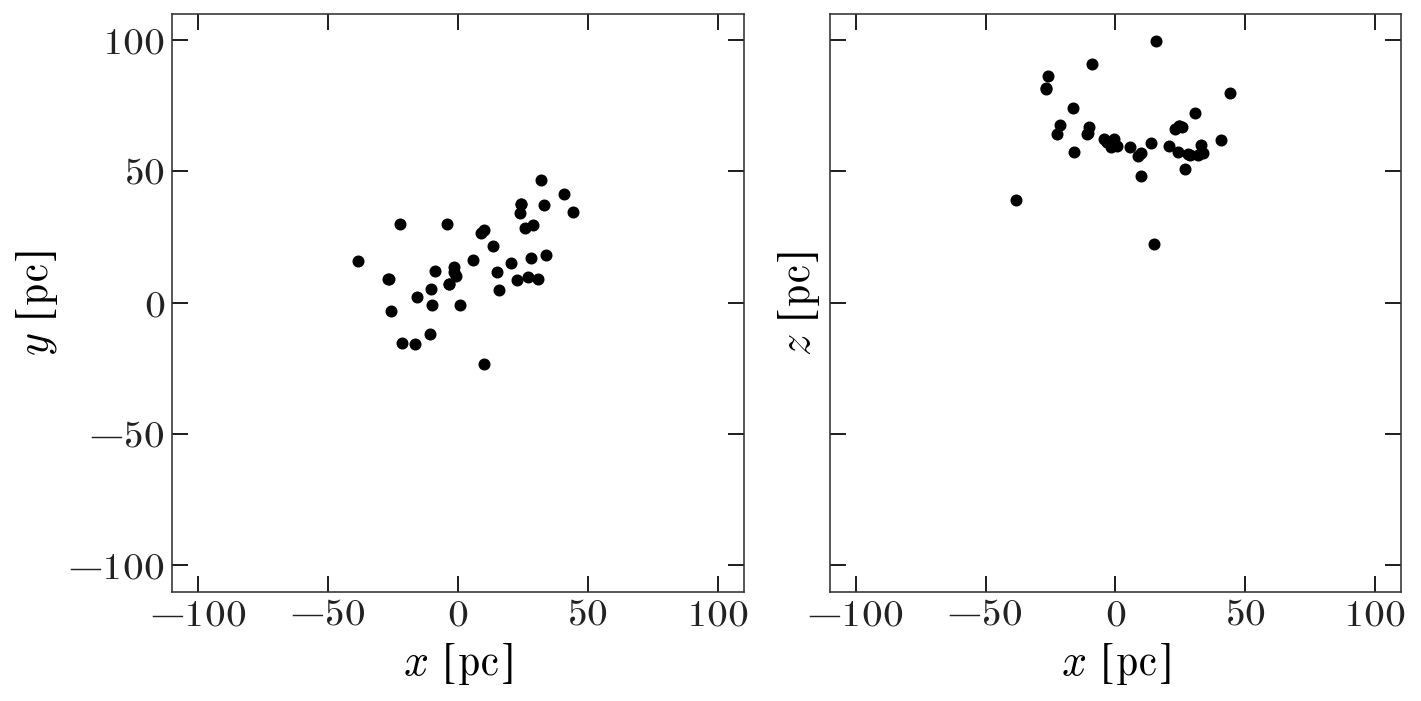

In [36]:
galcen = highprob_c.transform_to(coord.Galactocentric)

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

ax = axes[0]
ax.scatter((galcen.x - -galcen.galcen_distance).to_value(u.pc),
           galcen.y.to_value(u.pc))
ax.set_xlim(-110, 110)
ax.set_ylim(-110, 110)
ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$y$ [pc]')

ax = axes[1]
ax.scatter((galcen.x - -galcen.galcen_distance).to_value(u.pc),
           galcen.z.to_value(u.pc))

ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$z$ [pc]')

fig.tight_layout()